[View in Colaboratory](https://colab.research.google.com/github/fuulish/colab/blob/master/accumulation_test.ipynb)

Install necessary components

In [2]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    100% |████████████████████████████████| 592.3MB 37.5MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


general preparations

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.nn import init

import itertools

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
dtype = torch.FloatTensor

if use_cuda:
    dtype = torch.cuda.FloatTensor

create general model

In [0]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out, bias=None):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H)
        self.fc2 = torch.nn.Linear(H, H)
        self.fc3 = torch.nn.Linear(H, D_out)

        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2))
        init.xavier_uniform(self.fc2.weight, gain=np.sqrt(2))
        init.xavier_uniform(self.fc3.weight, gain=np.sqrt(2))

        if bias is not None:
            init.constant(self.fc3.bias, bias)
            self.fc3.bias.requires_grad = False

        # self.activation = torch.nn.ReLU()
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

prep data

In [0]:
natom = 10
npoint = 10000

x1 = np.random.rand(natom, npoint, 1)
x2 = np.random.rand(natom, npoint, 1)

y = np.sum(np.exp(-x1) + np.sin(x2), axis=0)

# x1 = 2.*(x1 - np.min(x1))/(np.max(x1)-np.min(x1)) - 1
# x2 = 2.*(x2 - np.min(x2))/(np.max(x2)-np.min(x2)) - 1

# x1 = (x1 - x1.mean()) / x1.std()
# x2 = (x2 - x2.mean()) / x2.std()

models = []
for x in [x1, x2]:
    model = Net(1, 10, 1) #, bias=x.mean())
    if use_cuda:
        model = model.cuda()
    models.append(model)

x1 = torch.autograd.Variable(torch.Tensor(x1).type(dtype))
x2 = torch.autograd.Variable(torch.Tensor(x2).type(dtype))

y = torch.autograd.Variable(torch.Tensor(y).type(dtype))

parmchain = itertools.chain()
for model in models:
    parmchain = itertools.chain(parmchain, model.parameters())

base_learning_rate = learning_rate = 1.e-1
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, parmchain), lr=learning_rate)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, parmchain), lr=learning_rate)

lambda1 = lambda epoch: 0.999**epoch
lambda1 = lambda epoch: 1.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

loss_func = torch.nn.MSELoss(size_average=True)

nepoch = 1000

def evaluate(models, features):
    y_pred = 0.
    for model, x in zip(models, features):
        y_pred += torch.sum(model(x), dim=0)

    return y_pred

optimize model

In [28]:
for t in range(nepoch):
    y_pred = evaluate(models, [x1, x2])

    optimizer.zero_grad()
    loss = loss_func(y_pred, y)
    loss.backward()

    optimizer.step()
    scheduler.step()

    if t % 10 == 0:
        print(t, loss.data.cpu()[0])

0 621.08203125
10 138.8348388671875
20 4.9570770263671875
30 13.362133979797363
40 1.6901253461837769
50 1.4829169511795044
60 0.6719591021537781
70 0.10760505497455597
80 0.11764436960220337
90 0.07165870070457458
100 0.03292161226272583
110 0.01613340526819229
120 0.009915653616189957
130 0.007666633464396
140 0.006767227780073881
150 0.006284095346927643
160 0.005932649597525597
170 0.005635642446577549
180 0.005365018267184496
190 0.005109759047627449
200 0.004870153032243252
210 0.004647109657526016
220 0.004438943695276976
230 0.004244574345648289
240 0.004063383210450411
250 0.003894534194841981
260 0.0037372459191828966
270 0.003590682987123728
280 0.003454048652201891
290 0.003326559439301491
300 0.003207455389201641
310 0.0030960189178586006
320 0.0029915671329945326
330 0.002893468365073204
340 0.002801131922751665
350 0.0027140153106302023
360 0.0026316270232200623
370 0.0025535086169838905
380 0.002479256596416235
390 0.002408502157777548
400 0.0023409128189086914
410 0.00

plot results

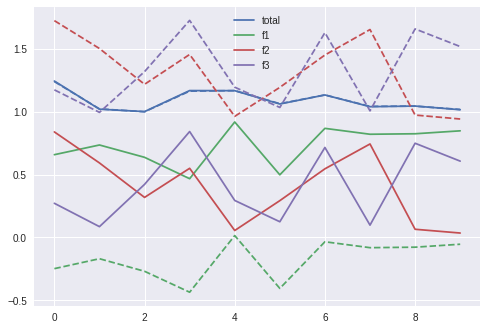

In [29]:
stride = 1000

p1 = plt.plot(y.data.cpu().numpy()[::stride] / natom, label='total')
p2 = plt.plot(np.exp(-x1[0].data.cpu().numpy().sum(axis=1))[::stride], label='f1')
p3 = plt.plot(np.sin(x2[0].data.cpu().numpy().sum(axis=1))[::stride], label='f2')
p4 = plt.plot(np.sin(x2[1].data.cpu().numpy().sum(axis=1))[::stride], label='f3')

plt.plot(evaluate(models, [x1,x2]).data.cpu().numpy()[::stride] / natom, '--', color=p1[0].get_color())
plt.plot(models[0](x1[0]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p2[0].get_color())
plt.plot(models[1](x2[0]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p3[0].get_color())
plt.plot(models[1](x2[1]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p4[0].get_color())

plt.legend()

plt.show()